# Maps in BARK

This notebook provides a short introduction to the map-format used in BARK.<br />
First, we will go into detail of the OpenDrive format, then we will give an overview of how to import and analyze maps and, finally, how they can be used and accessed within BARK.<br />
BARK extends the OpenDrive format by using a Roadgraph, MapInterface and Road- and Lane-Corridors.



## OpenDrive Format

Each map-file is represented in the OpenDrive format in which roads, junctions, and lanes are defined.

Each Road in the OpenDrive format has a PlanView that provides a geometric definition of the road (so to speak a center-line).
```xml
<planView>
   <geometry s="0" x="0" y="0" hdg="1.5707963267987366e+00" length="100">
      <line/>
   </geometry>
</planView>
```
The geometries with which the PlanView is defined are eithe lines, arcs or spirals.

Each Road has one or multiple LaneSections that define lanes for a certain length of the Road.
Within a LaneSection the number of lanes is constant.

A LaneSection has one or multiple lanes that are initially derived from the PlanViews geometry and then recursively from the inner lane's line.
```xml
<laneSection s="0.0000000000000000e+00">
   <lane id="3" type="sidewalk" level= "false">
      <link>
         <predecessor id="-1"/>
         <successor id="-1"/>
      </link>
      <width sOffset="0" a="1.5" b="0" c="0" d=-0"/>
   </lane>
</laneSection>
```
The *width* tag defines the lanes line that is derived from the PlanView or the inner lane's line.

Additionally, lanes and roads can have predecessors and successors.
For more complex linking -- such as intersections -- junctions can be used.
Junctions are defined by
```xml
<junction name="" id="2">
   <connection id="0" incomingRoad="8" connectingRoad="4" contactPoint="start">
      <laneLink from="1" to="-1"/>
      <laneLink from="2" to="-2"/>
      <laneLink from="3" to="-3"/>
   </connection>
</junction>
```
having lane-links and connections of the roads.

BARK stores the map in exactly the same structure as the OpenDrive-format.
The c++ implementation can be found in the folder `bark/world/opendrive/':

```
BUILD                   junction.hpp            lane_section.cpp        odrSpiral.hpp           plan_view.hpp
commons.hpp             lane.cpp                lane_section.hpp        opendrive.hpp           road.cpp
helpers.hpp             lane.hpp                odrSpiral.cpp           plan_view.cpp           road.hpp
```

For a more detailed specification visit the OpenDrive website at http://www.opendrive.org.

## Maps in BARK

To enable easier handling of the OpenDrive format, BARK implements a *RoadGraph* that contains all lane- and road-connections.<br />
The RoadGraph provides an abstraction layer and easy-to-use interface to query the OpenDrive format -- e.g. it can be used for routing.<br />
The implementation of the RoadGraph can be found in `bark/world/map/roadgraph.hpp'.

The *MapInterface* stores and provides access to both -- the OpenDrive format and the RoadGraph.<br />
It also generates the routing specific RoadCorridors and LaneCorridors.<br />
Each agent in BARK has at least one RoadCorridor.

The *RoadCorridor* can be seen as a route-specific OpenDrive road that the agent is allowed to act in.<br/>
The agent can e.g. query the RoadCorridor on which lane it currently is and if there are neighboring LaneCorridors that it can change to.
The LaneCorridors are concatenated consecutive lanes within the RoadCorridor.

All these definitions can be found within the `bark/world/map/' folder.

## Importing an OpenDrive Map

In the following, we will load the example intersection map provided on the OpenDrive website.<br/>
The XodrParser parses the OpenDrive xml-file and converts it to the BARK c++ OpenDrive structure.

In [1]:
import bark
from bark.runtime.commons.xodr_parser import XodrParser
xodr_parser = XodrParser("../../bark/runtime/tests/data/Crossing8Course.xodr")


## MapInterface
In this step, we create the MapInterface that provides an easy-to-use interface for the OpenDrive structure.<br />
As above-mentioned, the MapInterface provides a wide range of utility- and handling-functions.


In [2]:
from bark.runtime.commons.parameters import ParameterServer
from bark.core.world import World
from bark.core.world.map import MapInterface

params = ParameterServer()
world = World(params)
# create the MapInterface using the parsed OpenDrive file
map_interface = MapInterface()
map_interface.SetOpenDriveMap(xodr_parser.map)
world.SetMap(map_interface)

# to access the original OpenDrive map
open_drive_map = world.map.GetOpenDriveMap()

We now can visualize the parsed map and ensure it has been created properly:

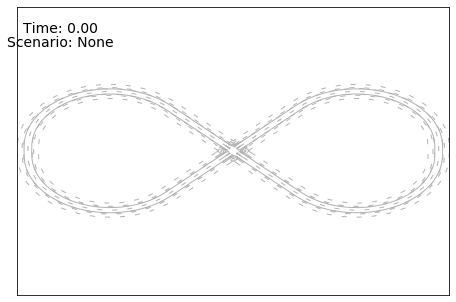

<Figure size 432x288 with 0 Axes>

In [3]:
from bark.runtime.viewer.matplotlib_viewer import MPViewer
import matplotlib.pyplot as plt
viewer = MPViewer(params=params,
                  use_world_bounds=True)
viewer.drawWorld(world)
viewer.show()
# viewer.clear()

The c++ OpenDrive structures in BARK can be also accessed using:

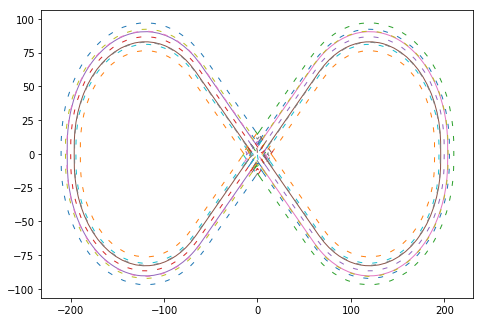

In [4]:
viewer = MPViewer(params=params,
                  use_world_bounds=True)
for idx_r, road in open_drive_map.GetRoads().items():
    for idx_ls, lane_section in enumerate(road.lane_sections):
        for idx_l, lane in lane_section.GetLanes().items():
            viewer.drawXodrLane(lane)
viewer.show()
viewer.clear()


The RoadGraph can be used for querying the OpenDrive structure:

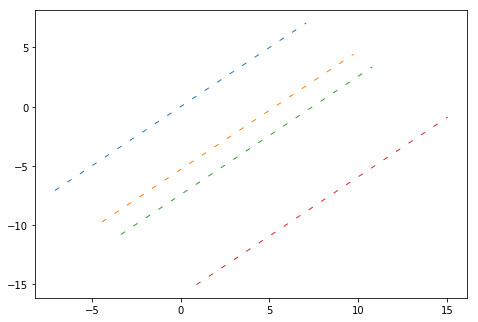

In [5]:
viewer = MPViewer(params=params,
                  use_world_bounds=True)
roadgraph = map_interface.GetRoadgraph()
# output the graph in dot-file
# roadgraph.PrintGraph(output_dir + "/" + map_name)
lane_ids = roadgraph.GetAllLaneids()

lane_polygon = roadgraph.GetLanePolygonForLaneId(lane_ids[34])
road_id = roadgraph.GetRoadForLaneId(lane_ids[34])
road = map_interface.GetOpenDriveMap().GetRoad(road_id)
plan_view_reference = road.plan_view.GetReferenceLine()
viewer.drawXodrRoad(road)
viewer.show()
viewer.clear()

A RoadCorridor can be computed by:

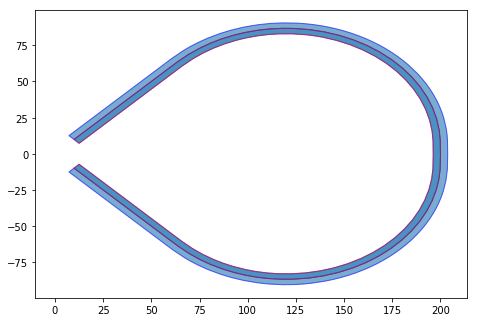

In [6]:
from bark.core.world.opendrive import *
viewer = MPViewer(params=params,
                  use_world_bounds=True)
roadgraph = map_interface.GetRoadgraph()
map_interface.GenerateRoadCorridor([508], XodrDrivingDirection.forward)
road_corridor = map_interface.GetRoadCorridor([508], XodrDrivingDirection.forward)
viewer.drawRoadCorridor(road_corridor)

lane_corridors = road_corridor.lane_corridors
viewer.drawLaneCorridor(lane_corridors[0], color="red")
# map through LaneCorridors
viewer.show()
viewer.clear()

The above-shown RoadCorridor can be assigned to an agent that is then acting within it using the agent's behavior model.